# Forecasting Consensus Expectations: Nonfarm Payrolls (NFP)

## Point and Directional Forecasts

**Imports**

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera

In [44]:
OUT_DIR = "../out"         
DF_FILE       = "df.parquet"
DF_FULL_FILE  = "df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (85303, 10)
df_full shape: (96751, 10)


## 3.0: Baseline static forecast on full sample

Rolling 6-month fixed window. For every valid economist (for a prediction at time t, has a contiguous 6-month forecast history for previous 6 releases), weight prediction by inverse MSE. 


This implements an out-of-sample error estimate with a rolling 6-month estimation window. Weights don't use information from the target month and actual value at month *t* is unseen. In other words, all errors are "live" errors that could have been observed in real time.

Briefly, the procedure: 
1. Starts at 7th release (for 6 month release prior)
2. From estimation window, keep economists that supplied a forecast for all six months (per contiguity rule)
3. Compute MSE for each economist using errors against already known actuals (no lookahead)
4. Generate forecast for release t 
5. Store OOS evaluation error
6. Roll window forward a month and repeat

RMSE - smart: 623.87 k jobs
RMSE - median:  631.48 k jobs
DM statistic:  -0.92
p-value: 0.3600


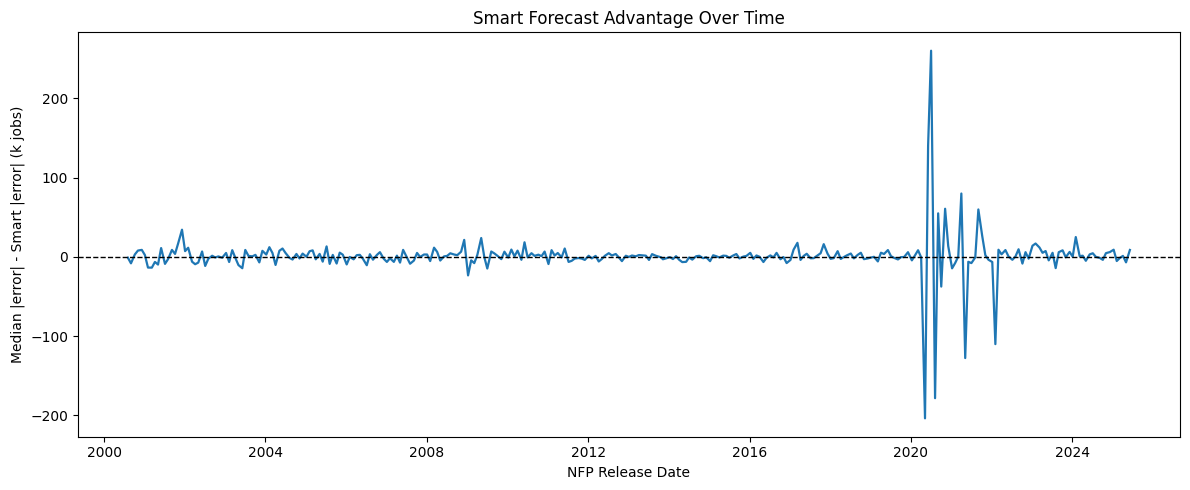

In [26]:
df_full["release_date"] = pd.to_datetime(df_full["release_date"])
dates = np.sort(df_full["release_date"].unique())

records = []        # collect out-of-sample predictions

for idx in range(6, len(dates)):
    t = dates[idx]      # target release 
    window = dates[idx-6:idx]       # six prior releases
    
    hist = df_full[df_full["release_date"].isin(window)]
    
    valid_mask = (hist.groupby("economist")["forecast"]
                  .apply(lambda s: s.notna().all()))
    
    valid_econ = valid_mask[valid_mask].index
    
    mse = (hist[hist["economist"].isin(valid_econ)]
           .groupby("economist")["error"]
           .apply(lambda s: np.nanmean(s.dropna()**2))
           .dropna())
    
    if valid_econ.empty:
        continue 
    
    ridge = 1e-6            # prevent weight blow-ups given small estimation window 
    weights = 1 / (mse + ridge)
    weights = weights / weights.sum() # normalize
    
    # target specific values 
    cur = df_full[(df_full["release_date"] == t) & 
             (df_full["economist"].isin(valid_econ))]
    f_t = cur.set_index("economist")["forecast"].dropna()
    
    # safeguard: economist may forecast past 6 releases, but may have no forecast for t
    # align & renormalize weights
    weights = weights[weights.index.isin(f_t.index)] 
    if weights.empty:
        continue
    weights = weights/weights.sum()     # renormalize
    
    yhat_smart = np.dot(weights, f_t.loc[weights.index])
    yhat_median = (df_full.loc[df_full["release_date"] == t, "forecast"].dropna().median())
    y_actual = df_full.loc[df_full["release_date"] == t,
                      "actual"].iloc[0]
    
    records.append((t, yhat_smart, yhat_median, y_actual))
    
oos = pd.DataFrame(records, 
                   columns = ["date", "smart", "median", "actual"])
oos["smart_err"] = oos["smart"] - oos["actual"]
oos["median_err"] = oos["median"] - oos["actual"]

rmse_smart = np.sqrt(np.mean(oos["smart_err"]**2))
rmse_median = np.sqrt(np.mean(oos["median_err"]**2))
print(f"RMSE - smart: {rmse_smart:6.2f} k jobs")
print(f"RMSE - median: {rmse_median: 6.2f} k jobs")

# Diebold-Mariano (DM) test: given two time series of loss, compute loss differential, test if the mean of this series of loss differential is statistically different from 0 

d = oos["smart_err"]**2 - oos["median_err"]**2
dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
p_val = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
print(f"DM statistic: {dm_stat: 6.2f}")
print(f"p-value: {p_val:.4f}")

# Visualize smart forecast advantage 
oos["improvement"] = (oos["median_err"].abs() - 
                      oos["smart_err"].abs())

plt.figure(figsize=(12,5))
plt.plot(oos["date"], oos["improvement"],
         color="tab:blue", linewidth=1.6)

plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.title("Smart Forecast Advantage Over Time")
plt.xlabel("NFP Release Date")
plt.ylabel("Median |error| - Smart |error| (k jobs)")
plt.tight_layout()
plt.show()

Noticeably erratic performance in COVID and subsequent aftermath (~2020-2022). Pertinent to subset out as 2020-2022 is unlikely to be generalizable to future performance.

## 3.1: Static Forecast, inverse-MSE weighted

Here, in addition to the level forecast, we also introduce a directional forecast. Briefly: 


**Directional–forecast procedure (Beat / Miss classification)**  
1. For each release, keep valid economists within contiguity filter 
2. For every valid economist, compute trailing 6-month MSE, convert to weights (inverse MSE), build smart point forecast via normalized inverse-MSE weighting
3. Label the realized print (true y) as beat == 1 if y_t > median_t, miss == 1 otherwise. Same labeling procedure for smart forecast. 
4. Compute hit-rate: Fraction of releases where predicted sign matches realized sign. Test significance with a binomial/PT test. 
5. Do this for contiguity windows of 6, 12, and 24 months

In [27]:
# Static forecast, full sample 
df_full["release_date"] = pd.to_datetime(df_full["release_date"])
dates = np.sort(df_full["release_date"].unique())

# Hyperparameters
contiguity_windows = [3, 6, 12, 24]
methods            = ["inverse_mse", "inverse_mae", "equal_weight"]
ridge              = 1e-6

results = []

# Grid search 
for window, method in tqdm(
        product(contiguity_windows, methods),
        desc="Grid search",
        total=len(contiguity_windows)*len(methods)
    ):
    records = []
    # walk-forward through release dates
    for idx in range(window, len(dates)):
        t            = dates[idx]
        window_dates = dates[idx-window:idx]
        hist         = df_full[df_full["release_date"].isin(window_dates)]
        
        # filter economists with full coverage
        valid = hist.groupby("economist")["forecast"] \
                    .apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # compute scores if needed
        if method in ("inverse_mse", "inverse_mae"):
            scores = {}
            for econ in econs:
                errs = hist.loc[hist["economist"] == econ, "error"].values
                if method == "inverse_mse":
                    scores[econ] = np.nanmean(errs**2)
                else:
                    scores[econ] = np.nanmean(np.abs(errs))
        
        # form weights
        if method == "equal_weight":
            w = pd.Series(1.0, index=econs)
        else:
            inv = {econ: 1.0/(scores[econ] + ridge) for econ in econs}
            w   = pd.Series(inv)
        w = w / w.sum()

        # current-month forecasts & align
        cur = df_full[
            (df_full["release_date"] == t) &
            (df_full["economist"].isin(w.index))
        ]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.loc[w.index.intersection(f_t.index)]
        if w.empty:
            continue
        w = w / w.sum()

        # point forecasts
        yhat_smart  = np.dot(w, f_t.loc[w.index])
        yhat_median = df_full.loc[df_full["release_date"] == t, "forecast"] \
                             .dropna().median()
        y_actual    = df_full.loc[df_full["release_date"] == t, "actual"].iloc[0]

        records.append((t, yhat_smart, yhat_median, y_actual))

    # assemble OOS table
    oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
    if oos.empty:
        continue
    oos["smart_err"]  = oos["smart"]  - oos["actual"]
    oos["median_err"] = oos["median"] - oos["actual"]
    oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)
    oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)

    # metrics
    obs         = len(oos)
    rmse_smart  = np.sqrt(np.mean(oos["smart_err"]**2))
    rmse_median = np.sqrt(np.mean(oos["median_err"]**2))
    hit_rate    = (oos["actual_dir"] == oos["pred_dir"]).mean()

    # Diebold–Mariano on squared error
    d        = oos["smart_err"]**2 - oos["median_err"]**2
    dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(obs)
    dm_p     = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

    # Binomial and PT tests for direction
    hits    = (oos["actual_dir"] == oos["pred_dir"]).astype(int)
    binom_p = stats.binomtest(hits.sum(), obs, 0.5).pvalue
    p1, p2  = oos["pred_dir"].mean(), oos["actual_dir"].mean()
    c       = (oos["pred_dir"] & oos["actual_dir"]).mean()
    pt_stat = (c - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
    pt_p    = 2 * (1 - stats.norm.cdf(abs(pt_stat)))

    results.append({
        "window":       window,
        "method":       method,
        "obs":          obs,
        "RMSE_smart":   rmse_smart,
        "RMSE_median":  rmse_median,
        "HitRate":      hit_rate,
        "Binom_p":      binom_p,
        "PT_stat":      pt_stat,
        "PT_p":         pt_p,
        "DM_stat":      dm_stat,
        "DM_p":         dm_p
    })

# compile and display best by RMSE_smart
res_df = pd.DataFrame(results).sort_values("RMSE_smart")
print(res_df.to_string(index=False, float_format="{:.3f}".format))

Grid search:   0%|          | 0/12 [00:00<?, ?it/s]

 window       method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
      6 equal_weight  299     583.154      631.481    0.582    0.005    2.902 0.004   -1.046 0.296
     12 equal_weight  293     589.487      637.801    0.563    0.035    2.195 0.028   -1.127 0.260
      6  inverse_mae  299     595.964      631.481    0.572    0.015    2.539 0.011   -1.041 0.298
      3 equal_weight  302     596.978      628.563    0.570    0.018    2.457 0.014   -1.151 0.250
     12  inverse_mae  293     600.256      637.801    0.560    0.047    2.093 0.036   -1.166 0.244
      3  inverse_mae  302     601.556      628.563    0.573    0.013    2.558 0.011   -1.139 0.255
     24 equal_weight  281     602.151      650.837    0.552    0.095    1.736 0.083   -1.087 0.277
     24  inverse_mae  281     608.507      650.837    0.548    0.121    1.615 0.106   -1.095 0.273
      3  inverse_mse  302     622.308      628.563    0.560    0.044    2.135 0.033   -1.191 0.234
      6  i

In [28]:
# Static forecast, COVID filtered out 

df["release_date"] = pd.to_datetime(df["release_date"])
dates = np.sort(df["release_date"].unique())

# Hyperparameters 
contiguity_windows = [3, 6, 12, 24]
methods            = ["inverse_mse", "inverse_mae", "equal_weight"]
ridge              = 1e-6

results = []

# Grid search 
for window, method in tqdm(
        product(contiguity_windows, methods),
        desc="Grid search",
        total=len(contiguity_windows)*len(methods)
    ):
    records = []
    # walk-forward through release dates
    for idx in range(window, len(dates)):
        t            = dates[idx]
        lookback_start = t - pd.DateOffset(months=window)   # lookback issue fix
        hist = df[(df["release_date"] >= lookback_start) &
              (df["release_date"] <  t)]
        
        # filter economists with full coverage in the window
        valid = hist.groupby("economist")["forecast"] \
                    .apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # compute scores if needed
        if method in ("inverse_mse", "inverse_mae"):
            scores = {}
            for econ in econs:
                errs = hist.loc[hist["economist"] == econ, "error"].values
                if method == "inverse_mse":
                    scores[econ] = np.nanmean(errs**2)
                else:  # inverse_mae
                    scores[econ] = np.nanmean(np.abs(errs))
        
        # form weights
        if method == "equal_weight":
            w = pd.Series(1.0, index=econs)
        else:
            inv = {econ: 1.0/(scores[econ] + ridge) for econ in econs}
            w   = pd.Series(inv)
        w = w / w.sum()

        # current-month forecasts & align
        cur = df[
            (df["release_date"] == t) &
            (df["economist"].isin(w.index))
        ]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.loc[w.index.intersection(f_t.index)]
        if w.empty:
            continue
        w = w / w.sum()

        # point forecasts
        yhat_smart  = np.dot(w, f_t.loc[w.index])
        yhat_median = df.loc[df["release_date"] == t, "forecast"] \
                         .dropna().median()
        y_actual    = df.loc[df["release_date"] == t, "actual"].iloc[0]

        records.append((t, yhat_smart, yhat_median, y_actual))

    # assemble OOS table
    oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
    if oos.empty:
        continue
    oos["smart_err"]  = oos["smart"]  - oos["actual"]
    oos["median_err"] = oos["median"] - oos["actual"]
    oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)
    oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)

    # evaluation metrics
    obs         = len(oos)
    rmse_smart  = np.sqrt(np.mean(oos["smart_err"]**2))
    rmse_median = np.sqrt(np.mean(oos["median_err"]**2))
    hit_rate    = (oos["actual_dir"] == oos["pred_dir"]).mean()

    # Diebold–Mariano on squared error
    d        = oos["smart_err"]**2 - oos["median_err"]**2
    dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(obs)
    dm_p     = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

    # Binomial and Pesaran–Timmermann tests for direction
    hits    = (oos["actual_dir"] == oos["pred_dir"]).astype(int)
    binom_p = stats.binomtest(hits.sum(), obs, 0.5).pvalue
    p1, p2  = oos["pred_dir"].mean(), oos["actual_dir"].mean()
    c       = (oos["pred_dir"] & oos["actual_dir"]).mean()
    pt_stat = (c - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
    pt_p    = 2 * (1 - stats.norm.cdf(abs(pt_stat)))

    results.append({
        "window":       window,
        "method":       method,
        "obs":          obs,
        "RMSE_smart":   rmse_smart,
        "RMSE_median":  rmse_median,
        "HitRate":      hit_rate,
        "Binom_p":      binom_p,
        "PT_stat":      pt_stat,
        "PT_p":         pt_p,
        "DM_stat":      dm_stat,
        "DM_p":         dm_p
    })

# compile and display best by RMSE_smart
res_df = pd.DataFrame(results).sort_values("RMSE_smart")
print(res_df.to_string(index=False, float_format="{:.3f}".format))

Grid search:   0%|          | 0/12 [00:00<?, ?it/s]

 window       method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
     24  inverse_mse  244      74.197       74.906    0.557    0.084    1.835 0.067   -1.197 0.231
     24  inverse_mae  244      74.249       74.906    0.549    0.141    1.578 0.115   -1.115 0.265
     24 equal_weight  244      74.441       74.906    0.549    0.141    1.564 0.118   -0.837 0.402
     12  inverse_mse  256      76.064       77.309    0.582    0.010    2.689 0.007   -2.284 0.022
     12  inverse_mae  256      76.274       77.309    0.555    0.091    1.868 0.062   -2.027 0.043
      6  inverse_mse  262      76.343       77.465    0.561    0.055    2.113 0.035   -1.955 0.051
      6  inverse_mae  262      76.438       77.465    0.565    0.041    2.227 0.026   -2.027 0.043
     12 equal_weight  256      76.595       77.309    0.555    0.091    1.851 0.064   -1.582 0.114
      6 equal_weight  262      76.623       77.465    0.584    0.008    2.882 0.004   -1.941 0.052
      3  i

Clearly, level edge is eroded over the entire sample due to huge variance during COVID. 
- We need to subset out COVID period forecasts (or account for heavy tails somehow) if we want a good level forecast
- Directional edge can be maintained even through crises periods. Keep 6 or 12 month lookback window.

Inverse MSE weighting with a 12-month contiguity window provides best results 

**Stratified Analysis**

In [29]:
# ── PREP ─────────────────────────────────────────────────────────
df_full["release_date"] = pd.to_datetime(df_full["release_date"])
dates = np.sort(df_full["release_date"].unique())

# ── DEFINE WINDOWS & REGIMES ─────────────────────────────────────
windows = [3, 6, 12]  # now test 3, 6 and 12 month contiguity
periods = {
    "2000-2007 (pre-GFC)":         ("2000-01-01", "2007-12-31"),
    "2008-2009 (GFC crisis)":      ("2008-01-01", "2009-12-31"),
    "2010-2019 (long expansion)":  ("2010-01-01", "2019-12-31"),
    "2020-2022 (COVID + rebound)": ("2020-01-01", "2022-12-31"),
    "2023-2025 (post-COVID)":      ("2023-01-01", "2025-12-31")
}

# ── STORAGE ────────────────────────────────────────────────────────
all_summaries = {}

# ── LOOP OVER WINDOWS ─────────────────────────────────────────────
for W in windows:
    # 1) build OOS table
    records = []
    for idx in tqdm(range(W, len(dates)), desc=f"Static {W}-mo ensemble"):
        t = dates[idx]
        window_dates = dates[idx-W:idx]
        hist = df_full[df_full["release_date"].isin(window_dates)]

        # full coverage filter
        valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # inverse-MSE weights
        mse   = (hist[hist["economist"].isin(econs)]
                 .groupby("economist")["error"]
                 .apply(lambda s: np.nanmean(s**2)))
        ridge = 1e-6
        w     = 1.0 / (mse + ridge)
        w    /= w.sum()

        # current forecast & align
        cur = df_full[
            (df_full["release_date"] == t) &
            (df_full["economist"].isin(w.index))
        ]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.loc[w.index.intersection(f_t.index)]
        if w.empty:
            continue
        w /= w.sum()

        # smart & median
        yhat_smart  = np.dot(w, f_t.loc[w.index])
        yhat_median = df_full.loc[df_full["release_date"] == t, "forecast"]\
                             .dropna().median()
        y_actual    = df_full.loc[df_full["release_date"] == t, "actual"].iloc[0]

        records.append((t, yhat_smart, yhat_median, y_actual))

    # assemble OOS DataFrame
    oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
    oos["smart_err"]  = oos["smart"]  - oos["actual"]
    oos["median_err"] = oos["median"] - oos["actual"]
    oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)
    oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)

    # 2) stratified summary for this window
    summary = []
    for label, (start, end) in tqdm(periods.items(), desc=f"Stratified ({W}m)"):
        sub = oos[(oos["date"] >= start) & (oos["date"] <= end)]
        if sub.empty:
            continue

        # Diebold–Mariano on squared errors
        d       = sub["smart_err"]**2 - sub["median_err"]**2
        dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
        dm_p    = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

        # Directional metrics
        hits    = (sub["actual_dir"] == sub["pred_dir"]).astype(int)
        n       = len(hits)
        hit_rate= hits.mean()
        binom_p = stats.binomtest(hits.sum(), n, 0.5).pvalue
        p1, p2  = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        c       = (sub["pred_dir"] & sub["actual_dir"]).mean()
        pt_stat = (c - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/n)
        pt_p    = 2 * (1 - stats.norm.cdf(abs(pt_stat)))

        summary.append({
            "Period":   label,
            "Obs":      n,
            "HitRate":  hit_rate,
            "Binom_p":  binom_p,
            "PT_stat":  pt_stat,
            "PT_p":     pt_p,
            "DM_stat":  dm_stat,
            "DM_p":     dm_p
        })

    all_summaries[W] = pd.DataFrame(summary)

# ── DISPLAY ───────────────────────────────────────────────────────
for W, df_sum in all_summaries.items():
    print(f"\n=== Stratified Results for {W}-Month Window ===")
    print(df_sum.to_string(index=False, float_format="{:.3f}".format))


Static 3-mo ensemble:   0%|          | 0/302 [00:00<?, ?it/s]

Stratified (3m):   0%|          | 0/5 [00:00<?, ?it/s]

Static 6-mo ensemble:   0%|          | 0/299 [00:00<?, ?it/s]

Stratified (6m):   0%|          | 0/5 [00:00<?, ?it/s]

Static 12-mo ensemble:   0%|          | 0/293 [00:00<?, ?it/s]

Stratified (12m):   0%|          | 0/5 [00:00<?, ?it/s]


=== Stratified Results for 3-Month Window ===
                     Period  Obs  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
        2000-2007 (pre-GFC)   92    0.554    0.348    0.673 0.501   -0.214 0.830
     2008-2009 (GFC crisis)   24    0.625    0.307    1.448 0.148   -1.088 0.276
 2010-2019 (long expansion)  120    0.508    0.927    0.209 0.835   -0.015 0.988
2020-2022 (COVID + rebound)   36    0.611    0.243    0.943 0.346   -1.174 0.240
     2023-2025 (post-COVID)   30    0.667    0.099    0.848 0.397   -1.657 0.097

=== Stratified Results for 6-Month Window ===
                     Period  Obs  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
        2000-2007 (pre-GFC)   89    0.517    0.832    0.118 0.906    0.047 0.962
     2008-2009 (GFC crisis)   24    0.750    0.023    2.342 0.019   -1.095 0.274
 2010-2019 (long expansion)  120    0.533    0.523    0.777 0.437   -1.470 0.142
2020-2022 (COVID + rebound)   36    0.556    0.618    0.021 0.983   -0.899 0.369
     2023-2025 

1. Ex-COVID, 12-month inverse MSE ensemble beats median in magnitude of accuracy and directional edge. 
2. Crisis behavior (stress tests): level advantage disappears (variance of economist forecast explodes), ensemble has surprising directional edge in 08-09 crisis. Highly significant. 
3. Regime dependence: Skill of our model is clearest in the long, stable 2010-2019 period. Post-COVID shows no significance yet. Weights may need dynamic updating. 

Favor 12-month contiguity window. Future implementations we should augment with a crisis-robust variant (student t-likelihood to account for tails, dynamic weights).

# 3.2 Exponentially Weighted Moving Average (EWMA)

We'll now include (and tune) a decay hyperparameter.

In [30]:
# prep
df["release_date"] = pd.to_datetime(df["release_date"])
dates  = np.sort(df["release_date"].unique())

windows = [3, 6, 12, 24]
decays  = np.arange(0.75, 1.00, 0.05)      # 0.75 … 0.95
ridge   = 1e-6

results = []

for window, lam in tqdm(product(windows, decays),
                         total=len(windows)*len(decays),
                         desc="EWMA tuning"):
    records = []

    for idx in range(window, len(dates)):
        t_date      = dates[idx]
        window_dates = dates[idx-window:idx]          # ← ordinal look-back
        hist        = df[df["release_date"].isin(window_dates)]

        # economists with complete coverage
        valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # EWMA kernel (oldest → newest)
        ew = lam ** np.arange(window-1, -1, -1)
        ew = ew / ew.sum()

        # EWMA-MSE per economist
        scores = {}
        for econ in econs:
            errs = (hist.loc[hist["economist"] == econ]
                          .sort_values("release_date")["error"]
                          .values)
            assert len(errs) == window, "Window length mismatch"
            scores[econ] = np.sum(ew * errs**2)

        # inverse-MSE weights
        w = pd.Series({e: 1/(scores[e]+ridge) for e in econs})
        w /= w.sum()

        # align with current forecasts
        cur = df[(df["release_date"] == t_date) & (df["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.loc[w.index.intersection(f_t.index)]
        if w.empty:
            continue
        w /= w.sum()

        yhat_smart  = np.dot(w, f_t.loc[w.index])
        yhat_median = df.loc[df["release_date"] == t_date, "forecast"].dropna().median()
        y_actual    = df.loc[df["release_date"] == t_date, "actual"].iloc[0]
        records.append((t_date, yhat_smart, yhat_median, y_actual))

    # --- OOS evaluation ------------------------------------------------------
    oos = pd.DataFrame(records, columns=["date", "smart", "median", "actual"])
    if oos.empty:
        continue

    oos["smart_err"]   = oos["smart"]  - oos["actual"]
    oos["median_err"]  = oos["median"] - oos["actual"]
    oos["actual_dir"]  = (oos["actual"] > oos["median"]).astype(int)
    oos["pred_dir"]    = (oos["smart"]  > oos["median"]).astype(int)

    obs         = len(oos)
    rmse_smart  = np.sqrt((oos["smart_err"]**2).mean())
    rmse_median = np.sqrt((oos["median_err"]**2).mean())
    hit_rate    = (oos["actual_dir"] == oos["pred_dir"]).mean()

    d        = oos["smart_err"]**2 - oos["median_err"]**2
    dm_stat  = d.mean()/d.std(ddof=1)*np.sqrt(obs)
    dm_p     = 2*(1 - stats.norm.cdf(abs(dm_stat)))

    hits     = (oos["actual_dir"] == oos["pred_dir"]).astype(int)
    binom_p  = stats.binomtest(hits.sum(), obs, 0.5).pvalue
    p1, p2   = oos["pred_dir"].mean(), oos["actual_dir"].mean()
    c_joint  = (oos["pred_dir"] & oos["actual_dir"]).mean()
    pt_stat  = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
    pt_p     = 2*(1 - stats.norm.cdf(abs(pt_stat)))

    results.append({
        "window":      window,
        "decay":       lam,
        "obs":         obs,
        "RMSE_smart":  rmse_smart,
        "RMSE_median": rmse_median,
        "HitRate":     hit_rate,
        "Binom_p":     binom_p,
        "PT_stat":     pt_stat,
        "PT_p":        pt_p,
        "DM_stat":     dm_stat,
        "DM_p":        dm_p
    })

res_df = pd.DataFrame(results).sort_values(["window", "decay"])
print(res_df.to_string(index=False, float_format="{:.3f}".format))


EWMA tuning:   0%|          | 0/20 [00:00<?, ?it/s]

 window  decay  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
      3  0.750  266      77.928       78.962    0.556    0.075    1.863 0.062   -1.433 0.152
      3  0.800  266      77.941       78.962    0.564    0.043    2.129 0.033   -1.431 0.153
      3  0.850  266      77.952       78.962    0.568    0.032    2.261 0.024   -1.427 0.154
      3  0.900  266      77.964       78.962    0.560    0.057    2.035 0.042   -1.422 0.155
      3  0.950  266      77.975       78.962    0.556    0.075    1.943 0.052   -1.417 0.156
      6  0.750  263      76.226       77.330    0.574    0.019    2.531 0.011   -1.898 0.058
      6  0.800  263      76.254       77.330    0.570    0.026    2.397 0.017   -1.871 0.061
      6  0.850  263      76.279       77.330    0.570    0.026    2.417 0.016   -1.848 0.065
      6  0.900  263      76.299       77.330    0.570    0.026    2.417 0.016   -1.830 0.067
      6  0.950  263      76.316       77.330    0.567    0.036    2.30

- lambda = 0.95 decay on a 12-month lookback window seems best
- 24-month lookback window benefits from strong decay. 12-month is optimized with mild decay (.9-.95). Decay doesn't change 6-month window much as window is already short. 
- For this dataset, exponential decay does not seem to provide a clear benefit. It actually weakens RMSE and directional significance. 
- Error pattern may be fairly stationary in the 12 month window. Discounting doesn't reveal new information. 
- Might be a bias-vairance tradeoff issue (e.g. lowers bias but increases in variance of weight estimates renders bias improvement null)
- Decay likely isn't necessary for a 12-month window

**Commentary**
- Static inverse-MSE, 12-mo window (COVID filtered) provides an easy win
- EWMA decay adds no discernible value 
- Extreme shocks erode level accuracy, directional skill persists

## 3.3 Rolling-window soft-BMA with Student-t plug-in likelihood

In [31]:
# Full sample, COVID included
df_full["release_date"] = pd.to_datetime(df_full["release_date"])
dates = np.sort(df_full["release_date"].unique())

# Hyperparameter grid 
windows = [3, 6, 12, 24]            # contiguity windows to test
nu_grid = [3, 5, 10, 20, 50]     # Student-t degrees of freedom
ridge   = 1e-6                   # small regularizer to avoid div/0

results = []

# Grid search 
for window in tqdm(windows, desc="Window size"):
    for nu in tqdm(nu_grid, desc=f"Tuning ν (window={window}m)", leave=False):
        records = []

        # walk-forward through release dates
        for idx in range(window, len(dates)):
            t_date   = dates[idx]
            lookback = dates[idx-window:idx]
            hist     = df_full[df_full["release_date"].isin(lookback)]

            # require economists with full coverage
            valid = (
                hist.groupby("economist")["forecast"]
                    .apply(lambda s: s.notna().all())
            )
            econs = valid[valid].index
            if econs.empty:
                continue

            # compute each economist's log-likelihood under Student-t
            log_w = {}
            for econ in econs:
                errs = hist.loc[hist["economist"] == econ, "error"] \
                           .dropna().values
                if errs.size == 0:
                    continue
                sigma = np.std(errs, ddof=1)
                log_w[econ] = student_t.logpdf(errs, df=nu, loc=0, scale=sigma).sum()
            if not log_w:
                continue

            # softmax → posterior weights
            e_list = list(log_w.keys())
            lw_arr = np.array([log_w[e] for e in e_list])
            w_unn  = np.exp(lw_arr - lw_arr.max())
            w_ser  = pd.Series(w_unn, index=e_list)
            w_ser /= w_ser.sum()

            # align with current forecasts
            cur     = df_full[
                (df_full["release_date"] == t_date) &
                (df_full["economist"].isin(w_ser.index))
            ]
            f_t     = cur.set_index("economist")["forecast"].dropna()
            weights = w_ser.loc[w_ser.index.intersection(f_t.index)]
            if weights.empty:
                continue
            weights /= weights.sum()

            # smart & median forecasts
            yhat_smart  = (weights * f_t).sum()
            yhat_median = df_full.loc[
                              df_full["release_date"] == t_date, "forecast"
                          ].dropna().median()
            y_actual    = df_full.loc[
                              df_full["release_date"] == t_date, "actual"
                          ].iloc[0]

            records.append((t_date, yhat_smart, yhat_median, y_actual))

        # build out-of-sample table
        if not records:
            continue
        oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
        oos["smart_err"]  = oos["smart"]  - oos["actual"]
        oos["median_err"] = oos["median"] - oos["actual"]

        # Directional metrics
        oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)
        oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)
        hits              = (oos["actual_dir"] == oos["pred_dir"]).astype(int)
        hit_rate          = hits.mean()
        binom_p           = binomtest(hits.sum(), len(oos), 0.5).pvalue
        p1, p2            = oos["pred_dir"].mean(), oos["actual_dir"].mean()
        c_joint           = (oos["pred_dir"] & oos["actual_dir"]).mean()
        pt_stat           = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/len(oos))
        pt_p              = 2 * (1 - norm.cdf(abs(pt_stat)))

        # Level metrics
        rmse_smart  = np.sqrt((oos["smart_err"]**2).mean())
        rmse_median = np.sqrt((oos["median_err"]**2).mean())

        # Diebold–Mariano on squared errors
        d       = oos["smart_err"]**2 - oos["median_err"]**2
        dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
        dm_p    = 2 * (1 - norm.cdf(abs(dm_stat)))

        # collect results
        results.append({
            "window":       window,
            "nu":           nu,
            "obs":          len(oos),
            "RMSE_smart":   rmse_smart,
            "RMSE_median":  rmse_median,
            "HitRate":      hit_rate,
            "Binom_p":      binom_p,
            "PT_stat":      pt_stat,
            "PT_p":         pt_p,
            "DM_stat":      dm_stat,
            "DM_p":         dm_p
        })

res_df = pd.DataFrame(results).sort_values("RMSE_smart")
print(res_df.to_string(index=False, float_format="{:.3f}".format))

Window size:   0%|          | 0/4 [00:00<?, ?it/s]

Tuning ν (window=3m):   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide b

Tuning ν (window=6m):   0%|          | 0/5 [00:00<?, ?it/s]

Tuning ν (window=12m):   0%|          | 0/5 [00:00<?, ?it/s]

Tuning ν (window=24m):   0%|          | 0/5 [00:00<?, ?it/s]

 window  nu  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
      3   3  302     640.451      628.563    0.550    0.095    1.765 0.078    1.079 0.281
      3   5  302     641.233      628.563    0.556    0.057    1.995 0.046    1.048 0.295
      3  10  302     642.002      628.563    0.550    0.095    1.774 0.076    1.017 0.309
      3  20  302     642.481      628.563    0.550    0.095    1.765 0.078    0.999 0.318
      3  50  302     642.811      628.563    0.546    0.120    1.645 0.100    0.987 0.324
      6   3  299     707.315      631.481    0.555    0.064    1.913 0.056    1.112 0.266
      6   5  299     708.796      631.481    0.562    0.037    2.157 0.031    1.110 0.267
      6  10  299     710.251      631.481    0.562    0.037    2.157 0.031    1.109 0.267
      6  20  299     711.161      631.481    0.565    0.028    2.283 0.022    1.109 0.267
      6  50  299     711.795      631.481    0.562    0.037    2.163 0.031    1.110 0.267
     12   

In [32]:
# COVID-filtered sample
df["release_date"] = pd.to_datetime(df["release_date"])
dates = np.sort(df["release_date"].unique())

# hyperparameter grid 
windows = [3, 6, 12, 24]            # contiguity windows to test
nu_grid = [3, 5, 10, 20, 50]     # Student-t degrees of freedom
ridge   = 1e-6                   # small regularizer to avoid div/0

results = []

# grid search 
for window in tqdm(windows, desc="Window size"):
    for nu in tqdm(nu_grid, desc=f"Tuning ν (window={window}m)", leave=False):
        records = []
        # walk-forward through release dates
        for idx in range(window, len(dates)):
            t_date   = dates[idx]
            lookback = dates[idx-window:idx]
            hist     = df[df["release_date"].isin(lookback)]

            # require economists with full coverage
            valid = (
                hist.groupby("economist")["forecast"]
                    .apply(lambda s: s.notna().all())
            )
            econs = valid[valid].index
            if len(econs) == 0:
                continue

            # compute each economist's log-likelihood under Student-t
            log_w = {}
            for econ in econs:
                errs = hist.loc[hist["economist"] == econ, "error"].dropna().values
                if errs.size == 0:
                    continue
                sigma = np.std(errs, ddof=1)
                log_w[econ] = student_t.logpdf(errs, df=nu, loc=0, scale=sigma).sum()
            if not log_w:
                continue

            # softmax → posterior weights
            e_list = list(log_w.keys())
            lw_arr = np.array([log_w[e] for e in e_list])
            w_unn  = np.exp(lw_arr - lw_arr.max())
            w_ser  = pd.Series(w_unn, index=e_list)
            w_ser /= w_ser.sum()

            # align with current forecasts
            cur     = df[
                (df["release_date"] == t_date) &
                (df["economist"].isin(w_ser.index))
            ]
            f_t     = cur.set_index("economist")["forecast"].dropna()
            weights = w_ser.loc[w_ser.index.intersection(f_t.index)]
            if weights.empty:
                continue
            weights /= weights.sum()

            # smart & median forecasts
            yhat_smart  = (weights * f_t).sum()
            yhat_median = df.loc[df["release_date"] == t_date, "forecast"] \
                              .dropna().median()
            y_actual    = df.loc[df["release_date"] == t_date, "actual"].iloc[0]

            records.append((t_date, yhat_smart, yhat_median, y_actual))

        # build out-of-sample table
        if not records:
            continue
        oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
        oos["smart_err"]  = oos["smart"]  - oos["actual"]
        oos["median_err"] = oos["median"] - oos["actual"]

        # ── Directional metrics ───────────────────────────────────
        oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)
        oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)
        hits              = (oos["actual_dir"] == oos["pred_dir"]).astype(int)
        hit_rate          = hits.mean()
        binom_p           = binomtest(hits.sum(), len(oos), 0.5).pvalue
        p1, p2            = oos["pred_dir"].mean(), oos["actual_dir"].mean()
        c_joint           = (oos["pred_dir"] & oos["actual_dir"]).mean()
        pt_stat           = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/len(oos))
        pt_p              = 2 * (1 - norm.cdf(abs(pt_stat)))

        # Level metrics
        rmse_smart  = np.sqrt((oos["smart_err"]**2).mean())
        rmse_median = np.sqrt((oos["median_err"]**2).mean())

        # Diebold–Mariano on squared errors
        d        = oos["smart_err"]**2 - oos["median_err"]**2
        dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
        dm_p     = 2 * (1 - norm.cdf(abs(dm_stat)))

        # collect
        results.append({
            "window":       window,
            "nu":           nu,
            "obs":          len(oos),
            "RMSE_smart":   rmse_smart,
            "RMSE_median":  rmse_median,
            "HitRate":      hit_rate,
            "Binom_p":      binom_p,
            "PT_stat":      pt_stat,
            "PT_p":         pt_p,
            "DM_stat":      dm_stat,
            "DM_p":         dm_p
        })

# report 
res_df = pd.DataFrame(results).sort_values("RMSE_smart")
print(res_df.to_string(index=False, float_format="{:.3f}".format))


Window size:   0%|          | 0/4 [00:00<?, ?it/s]

Tuning ν (window=3m):   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide b

Tuning ν (window=6m):   0%|          | 0/5 [00:00<?, ?it/s]

Tuning ν (window=12m):   0%|          | 0/5 [00:00<?, ?it/s]

Tuning ν (window=24m):   0%|          | 0/5 [00:00<?, ?it/s]

 window  nu  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
     24   3  245      74.278       74.767    0.547    0.160    1.468 0.142   -0.402 0.688
     24   5  245      74.294       74.767    0.535    0.307    1.079 0.281   -0.382 0.702
     24  10  245      74.342       74.767    0.539    0.250    1.212 0.225   -0.335 0.738
     24  20  245      74.408       74.767    0.547    0.160    1.446 0.148   -0.276 0.782
     24  50  245      74.490       74.767    0.551    0.125    1.569 0.117   -0.208 0.835
     12  50  257      75.184       77.172    0.576    0.018    2.439 0.015   -1.399 0.162
     12  20  257      75.200       77.172    0.576    0.018    2.439 0.015   -1.407 0.159
     12  10  257      75.231       77.172    0.576    0.018    2.439 0.015   -1.407 0.159
     12   5  257      75.288       77.172    0.584    0.009    2.676 0.007   -1.394 0.163
     12   3  257      75.345       77.172    0.576    0.018    2.415 0.016   -1.371 0.170
      6  1

**Observations**

Student-t, relative to inverse MSE modeling, downweights big misses. This drops the RMSE. However, day-to-day volatility of improvement also rises (weights fuctuate more). DM statistic is proportional to average drop in squared error and inversely proportional to s.d. of those drops. As such, we see an improvement in RMSE that is not statistically significant at 5% per the DM test. Inverse MSE delivers more consistent small-to-medium wins, while student-t wins bigger when there is an outlier. 

## 3.X Confidence Interval testing

In [34]:
import numpy as np
import pandas as pd
from scipy.stats import t
from tqdm.auto import tqdm

# ── 1) Interval function ───────────────────────────────────────────
def student_t_interval(point_forecast, nu, loc, scale, level):
    """
    Returns the two‐sided (1−α) prediction bounds around point_forecast,
    where the error distribution is assumed Student-t(df=nu, loc, scale).
    """
    # critical quantile
    q = t.ppf(1 - (1 - level) / 2, df=nu)
    lower = point_forecast + loc - q * scale
    upper = point_forecast + loc + q * scale
    return lower, upper


In [35]:
# ── 2) Out‐of‐sample CI coverage test ────────────────────────────────

#  a) PREP
df["release_date"] = pd.to_datetime(df["release_date"])
# only start when we have at least 10 years of history
df = df[df["release_date"] >= "2010-01-01"].copy()  

# assume df has columns: release_date, median_forecast, actual
dates = df["release_date"].sort_values().unique()

# confidence levels to check
levels = [0.60, 0.70, 0.80, 0.90, 0.99]

# counters
coverage_hits = {ℓ: 0 for ℓ in levels}
n_tests = 0

# minimum # releases to fit initially
min_train_releases = 12

#  b) FORWARD‐CHAINING folds
for idx in tqdm(range(min_train_releases, len(dates)), desc="CI folds"):
    test_date = dates[idx]
    train_dates = dates[:idx]
    
    # training slice
    train = df[df["release_date"].isin(train_dates)]
    # errors of the **median** forecast during training
    errs = (train["median_forecast"] - train["actual"]).dropna().values
    
    # need enough data
    if len(errs) < min_train_releases:
        continue
    
    # 1) fit Student-t to training errors
    nu_hat, loc_hat, scale_hat = t.fit(errs)
    # optional clamp to avoid crazy ν
    nu_hat = np.clip(nu_hat, 3, 50)
    
    # 2) pull the test‐fold row
    row = df[df["release_date"] == test_date].iloc[0]
    pf = row["median_forecast"]
    actual = row["actual"]
    
    # 3) for each level, check if actual falls in the interval
    for ℓ in levels:
        lo, hi = student_t_interval(pf, nu_hat, loc_hat, scale_hat, ℓ)
        if lo <= actual <= hi:
            coverage_hits[ℓ] += 1
    
    n_tests += 1

#  c) summarize
coverage = {ℓ: coverage_hits[ℓ] / n_tests for ℓ in levels}
cov_df = pd.DataFrame({
    "nominal_level": levels,
    "empirical_coverage": [coverage[ℓ] for ℓ in levels]
})

print(cov_df.to_string(index=False, float_format="{:.3f}".format))


CI folds:   0%|          | 0/138 [00:00<?, ?it/s]

 nominal_level  empirical_coverage
         0.600               0.601
         0.700               0.688
         0.800               0.746
         0.900               0.884
         0.990               0.993


In [45]:
import numpy as np, pandas as pd
from scipy import stats
from tqdm.auto import tqdm
from collections import defaultdict

# ------------------------------------------------------------------
# Helper: Two–sided Student-t prediction interval
# ------------------------------------------------------------------
def student_t_interval(point, ν, loc, scale, level):
    """
    Return lower / upper bounds of a (100·level %) prediction interval
    centred on *point* and the fitted Student-t error distribution.
    """
    q = stats.t.ppf(1 - (1 - level) / 2, df=ν)          # two-sided critical value
    lower = point + loc - q * scale
    upper = point + loc + q * scale
    return lower, upper


# ------------------------------------------------------------------
# 1️⃣  Configuration
# ------------------------------------------------------------------
levels = [0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

# expanding / forward-chaining folds
folds = [
    ("2010-12-31", "2011-01-01", "2013-12-31"),
    ("2013-12-31", "2014-01-01", "2016-12-31"),
    ("2016-12-31", "2017-01-01", "2019-12-31"),
    ("2019-12-31", "2020-01-01", "2022-12-31"),  # will be empty if COVID yrs removed
    ("2022-12-31", "2023-01-01", None),          # None → to most-recent release
]

# make sure dates are real datetime64
df["release_date"] = pd.to_datetime(df["release_date"])

# ------------------------------------------------------------------
# 2️⃣  Running totals (across *all* test-set releases)
# ------------------------------------------------------------------
tot_N        = 0                              # total number of test releases
tot_cover_med = defaultdict(int)              # hit counter by level


# ------------------------------------------------------------------
# 3️⃣  Loop over folds
# ------------------------------------------------------------------
for train_end, test_start, test_end in tqdm(folds, desc="Folds"):

    # ---------------- Split train / test ----------------
    train = df[df.release_date <= train_end]

    test_mask = df.release_date >= test_start
    if test_end is not None:
        test_mask &= df.release_date <= test_end
    test = df[test_mask]

    if test.empty:
        continue    # nothing to score in this fold

    # ---------------- Fit Student-t to median errors on TRAIN ----------------
    train_med = (
        train.drop_duplicates("release_date")
             .assign(err=lambda d: d.median_forecast - d.actual)
             ["err"]
             .values
    )
    ν_m, loc_m, sc_m = stats.t.fit(train_med)

    # ---------------- Score TEST releases ----------------
    for d in test.release_date.sort_values().unique():

        actual   = test.loc[test.release_date == d, "actual"].iloc[0]
        med_fc   = test.loc[test.release_date == d, "median_forecast"].median()

        for L in levels:
            lo, hi = student_t_interval(med_fc, ν_m, loc_m, sc_m, L)
            if lo <= actual <= hi:
                tot_cover_med[L] += 1

        tot_N += 1


# ------------------------------------------------------------------
# 4️⃣  Coverage summary
# ------------------------------------------------------------------
summary = pd.DataFrame({
    "nominal_level":    levels,
    "empirical_coverage": [tot_cover_med[L] / tot_N for L in levels],
})

print("\nCoverage summary across all folds")
print(summary.to_string(index=False, float_format="{:.3f}".format))


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Coverage summary across all folds
 nominal_level  empirical_coverage
         0.600               0.652
         0.700               0.761
         0.800               0.833
         0.900               0.928
         0.950               0.971
         0.990               0.993


In [47]:
import numpy as np, pandas as pd
from scipy import stats
from tqdm.auto import tqdm
from collections import defaultdict

# ── CONFIG ───────────────────────────────────────────────────────
levels     = [0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
min_train  = 36     # need at least N releases before we start testing

# ── 1)  Make sure dates are chronological and compute median forecast --- 
df["release_date"] = pd.to_datetime(df["release_date"])
df = df.sort_values("release_date")

per_release = (df
    .groupby("release_date")
    .agg(
        median_fc=("median_forecast", "median"),   # already present in df
        actual    =("actual",          "first")
    )
)
per_release["err"] = per_release["median_fc"] - per_release["actual"]

dates = per_release.index.to_list()

# ── 2)  Counters for overall coverage ────────────────────────────
tot_N    = 0
hits_med = defaultdict(int)

# ── 3)  Rolling-origin loop ──────────────────────────────────────
for i in tqdm(range(min_train, len(dates)), desc="Rolling"):
    
    # split train / test
    train_err = per_release.iloc[:i]["err"].values           # errors up to t-1
    test_row  = per_release.iloc[i]                          # current release
    
    # fit Student-t on TRAIN
    ν_hat, loc_hat, scale_hat = stats.t.fit(train_err)
    
    # build prediction interval around the *median* forecast of this release
    point = test_row["median_fc"]
    actual = test_row["actual"]
    
    for L in levels:
        q      = stats.t.ppf(1 - (1 - L)/2, df=ν_hat)
        lower  = point + loc_hat - q * scale_hat
        upper  = point + loc_hat + q * scale_hat
        if lower <= actual <= upper:
            hits_med[L] += 1
    
    tot_N += 1

# ── 4)  Summarise empirical vs nominal coverage ──────────────────
summary = pd.DataFrame({
    "nominal_level":      levels,
    "empirical_coverage": [hits_med[L] / tot_N for L in levels],
})

print("\nRolling-origin prediction-interval coverage:")
print(summary.to_string(index=False, float_format="{:.3f}".format))


Rolling:   0%|          | 0/233 [00:00<?, ?it/s]


Rolling-origin prediction-interval coverage:
 nominal_level  empirical_coverage
         0.600               0.601
         0.700               0.708
         0.800               0.794
         0.900               0.918
         0.950               0.970
         0.990               0.991
